<a href="https://colab.research.google.com/github/Sanchithajp/Tele_customer_churn_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.1
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285391 sha256=ea0759afa0df837980796e9df291fbdc7c3671f4c9004c8a64778863fed9cd3c
  Stored in directory: /root/.cache/pip/wheels/e9/b4/d8/38accc42606f6675165423e9f0236f8e825f6b6b6048d6743e
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.5
    Uninstalling pyspark-3.5.5:
      Successfully uninstalled pyspark-3.5.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-spark-connect 0.5.2 requires pyspark>=3.5, but you have pyspark 3.4.1 which is incompatible.


In [4]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Telco_Customer_Churn.csv'
spark = SparkSession.builder \
    .appName("Telco Churn Analysis") \
    .getOrCreate()
data = spark.read.csv(file_path, header=True, inferSchema=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Show the first few rows
data.show(5)
# Print schema of the dataset
data.printSchema()



+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [6]:
# Drop 'customerID' column
data = data.drop("customerID")

# Convert TotalCharges to numeric and handle errors
data = data.withColumn("TotalCharges", col("TotalCharges").cast("double"))

# Count missing values in each column
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

# Drop rows with missing values
data = data.na.drop()
# Encode 'Churn' as binary (1 for 'Yes', 0 for 'No')
data = data.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

# Identify categorical columns
categorical_columns = [col for col in data.columns if data.select(col).distinct().count() < 10 and col != "Churn"]


+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|          11|   

In [7]:
# Apply StringIndexer and OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_columns]

# Apply transformations
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + encoders)
data = pipeline.fit(data).transform(data)
# Collect feature columns (encoded + numerical columns)
encoded_columns = [col + "_encoded" for col in categorical_columns]
numerical_columns = [col for col in data.columns if col not in categorical_columns + ["Churn"]]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=encoded_columns + numerical_columns, outputCol="features")
data = assembler.transform(data).select("features", "Churn")


+--------------------+-----+----------+--------------------+
|            features|Churn|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(73,[0,1,2,3,4,5,...|    1|       1.0|[0.28649380049542...|
|(73,[0,1,2,3,4,5,...|    1|       1.0|[0.28940795832147...|
|(73,[0,1,2,3,4,5,...|    0|       1.0|[0.29005792997715...|
|(73,[0,1,2,3,4,5,...|    0|       1.0|[0.29299345427065...|
|(73,[0,1,2,3,4,5,...|    1|       1.0|[0.32194514522217...|
+--------------------+-----+----------+--------------------+
only showing top 5 rows

ROC-AUC Score: 0.85


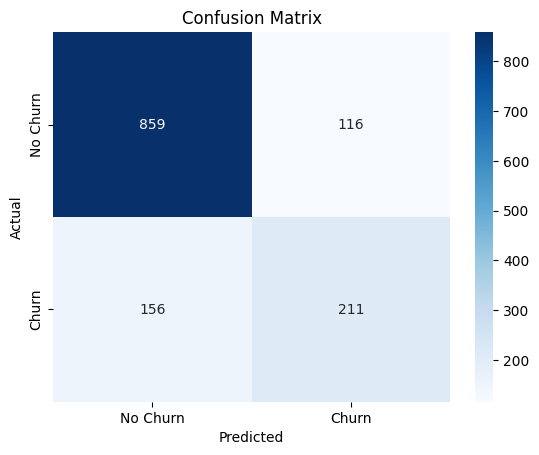

In [9]:
# Split dataset into training and testing sets (80-20 split)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Churn")

# Train the model on training data
lr_model = lr.fit(train_data)

# Predict on test data
predictions = lr_model.transform(test_data)
predictions.select("features", "Churn", "prediction", "probability").show(5)
# Evaluate the model using Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Churn", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {roc_auc:.2f}")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming `predictions` is your DataFrame containing model predictions
y_true = predictions.select("Churn").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()